# Conditional, observed conditional, and predictive power

## Preliminaries

In [1]:
import Pkg; Pkg.activate("..")
import QuadGK
using Distributions, Zygote, JuMP, Ipopt, DataFrames

# want to plot in R
using RCall
@rlibrary ggplot2
R"
library(tidyverse)
library(patchwork)
library(adoptr)
"

Activating environment at `~/workspace/unblinded-sample-size-reassessment/Project.toml`


┌ Warning: RCall.jl: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
│ ✔ ggplot2 3.3.1           ✔ purrr   0.3.4      
│ ✔ tibble  3.0.1           ✔ dplyr   0.8.99.9003
│ ✔ tidyr   1.0.2           ✔ stringr 1.4.0      
│ ✔ readr   1.3.1           ✔ forcats 0.4.0      
│ ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
│ ✖ dplyr::filter() masks stats::filter()
│ ✖ dplyr::lag()    masks stats::lag()
└ @ RCall /Users/kevin/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: 
│ Attaching package: ‘adoptr’
│ 
│ The following object is masked from ‘package:dplyr’:
│ 
│     n
│ 
└ @ RCall /Users/kevin/.julia/packages/RCall/Qzssx/src/io.jl:160


RObject{StrSxp}
 [1] "adoptr"    "patchwork" "forcats"   "stringr"   "dplyr"     "purrr"    
 [7] "readr"     "tidyr"     "tibble"    "ggplot2"   "tidyverse" "stats"    
[13] "graphics"  "grDevices" "utils"     "datasets"  "methods"   "base"     


In [2]:
# Gauss quadrature pivots and weights
ξ, ω = QuadGK.gauss(50)
# rule for interval [a, b]
integrate(f, a, b) = (b-a)/2 * sum(ω.*f.((b-a)/2 .* ξ .+ (a + b)/2))
# rule for interval [a, Inf)
function integrate(f, a)
    g(t) = f.(a .+ t ./ (1 .- t)) ./ (1 .- t).^2
    integrate(g, 0, 1)
end
# rule for interval (-Inf, a]
function integrate2(f, a)
    g(t) = f.(a .- (1 - t) ./ t) ./ t.^2
    integrate(g, 0, 1)
end
# rule for interval (-Inf, Inf)
function integrate(f)
    g(t) = f.(t ./ (1 .- t.^2)) .* (1 .+ t.^2) ./ (1 .- t.^2).^2
    integrate(g, -1, 1)
end

integrate (generic function with 3 methods)

$$
\newcommand{\Pr}{\operatorname{Pr}}
\newcommand{\CP}{\operatorname{CP}}
\newcommand{\OCP}{\operatorname{OCP}}
\newcommand{\PP}{\operatorname{PP}}
\newcommand{\PoS}{\operatorname{PoS}}
\newcommand{\crit}{z_{1-\alpha}}
\newcommand{\cond}{\,|\,}
$$

## Clinical trial example: initial sample size

We consider a single arm superiority trial to test $\mathcal{H}_0:\theta\leq 0$ based on the test statistic

$$
Z_n := \frac{1}{\sqrt{n}}\sum_{i=1}^n X_i, \quad \operatorname{E}[\,X_i\,] = \theta,\quad \operatorname{V}[\,X_i\,] = 1
$$

for independent and identically distributed $X_i$. 
All following considerations can easily be generalised to the practically more relevant two-arm superiority case. 
We merely discuss the single-arm case for the sake of simplicity in terms of notation.
The test statistic is asymptotically normal

$$
Z_n\stackrel{\cdot}{\sim}\mathcal{N}\big(\sqrt{n}\,\theta, 1\big) \ .
$$

We further assume that there is prior information that can be summarized in a normal prior with density

$$
\varphi(\theta) := \phi\left(\frac{\theta - 0.4}{0.2}\right)
$$

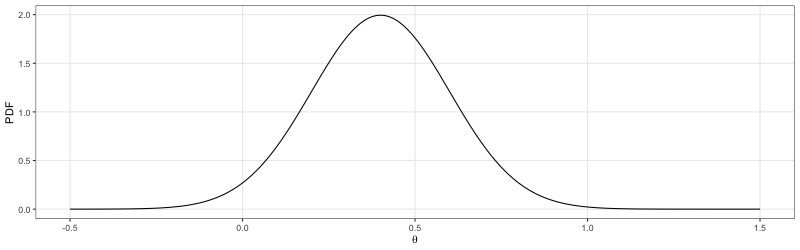

RObject{VecSxp}


In [3]:
φ(θ) = pdf(Normal(0.4, 0.2), θ)
   θ = collect(-0.5:0.01:1.5)

tbl_priors = DataFrame(
     theta = θ,
    normal = φ.(θ)
)

@rput tbl_priors
R"tbl_priors <- pivot_longer(tbl_priors, -theta, names_to = 'prior')"
tbl_priors = @rget tbl_priors

RCall.rcall_p(:options, rcalljl_options=Dict(:width => 800, :height => 250))
R"ggplot($tbl_priors) +
    aes(theta, value) +
    geom_line() +
    theme_bw() + 
    labs(x = expression(theta), y = 'PDF') +
    theme(
        legend.position = 'top',
        panel.grid.minor = element_blank()
    )"

In [4]:
ggsave("prior-density.pdf", width = 8, height = 3.5)

RObject{NilSxp}
NULL


To dermine the sample size $n$, we assume that the maximal acceptable type one error rate is $\alpha=0.025$ and an expected power [???] of $1-\beta=0.8$ is targeted.

In [5]:
   α = 0.025
crit = quantile(Normal(), 1 - α)

function EP(n, prior) 
         norm = integrate(prior, 0)
    cprior(θ) = prior(θ)/norm
    integrate(θ -> (1 - cdf(Normal(√(n)*θ, 1), crit))*cprior(θ), 0)
end

EP (generic function with 1 method)

In [6]:
round.(EP.(78:80, φ);  sigdigits = 3)

3-element Array{Float64,1}:
 0.799
 0.801
 0.803

A sample size of $n = 79$ is this sufficient to fulfill both error rate constraints. 

In [7]:
n = 79 

79

## Unplanned interim analyses

We now consider a situation where - for whatever reason - an unblinded interim analysis is conducted after $m=26$ outcomes have been observed. [todo: how is that usually justified?]

The sponsor then wants to reassess the prospects of successfully rejecting the null hypothesis at the end if the trial. Mainly four quantities are discussed in the literature in this context. 

In [8]:
m = 26

26

### Conditional power

We define conditional power as the probability to ultimately reject the
null hypothesis when $m < n$ outcomes are observed where $n$ is the final sample size

\begin{align}
\CP(z_m, \crit, \theta) :&= \Pr_\theta[\,Z_n > \crit \cond Z_m = z_m\,] \\
    &= 1 - \Phi\left(
            \frac{\crit - \sqrt{n}\,\theta - \sqrt{\tau} \, z_m + \sqrt{m}\,\theta
            }{\sqrt{1 - \tau}}
        \right) \ .
\end{align}

In [9]:
function CP(zm, n, m, c, θ)
    τ = m/n
    if τ >= 1
        return 0.0
    end
    μ = √(n)*θ + √(τ)*(zm - √(m)*θ)
    σ = √(1 - τ)
    1 - cdf(Normal(μ, σ), c)
end

CP (generic function with 1 method)

Note that the expression $\CP(z_m, \crit, \theta)$ depends on the unknown effect size $\theta$. 
Often the sample size $n$ is not based on expected power but simply the power at a point alternative $\theta_1>0$.
Conditional power is then often used to synomously refer to $\CP(z_m, \crit, \theta_1)$ where the unknown effect size is simply replaced with the effect size underlying the sample size calculation. 
Although we derived $n$ using predictive power and the prior density $\varphi(\cdot)$, we can mimmic the process by plugging in the prior mean, $0.4$.
To make the distinction between $\CP(z_m, \crit, \theta)$ and $\CP(z_m, \crit, \theta_1)$ explicit, we refer to the latter one as 'assumed conditional power' or ACP. 

### Observed conditional power

An alternative approach sometimes cited in the literature [The reassessment of trial perspectives from interimdata—a critical view] is to use the
maximum likelihood estimator for $\theta$, $\widehat{\theta}(z_m):=z_m/\sqrt{m}$, as plug-in.
We then define observed conditional power as
$$
\OCP(z_m, \crit) := \CP\big(z_m, \crit, \widehat{\theta}(z_m)\big) \ .
$$

In [10]:
OCP(zm, n, m, c) = CP(zm, n, m, c, zm/sqrt(m))

OCP (generic function with 1 method)

### Predictive power

A more principled approach is given by simply conditioning expected power on the observed interim outcome $Z_m = z_m$.
This quantity has been termed predictive power in the literature although 'conditional expected power' might be a more fitting term. 
In contrast to most previous authors [???] we are consistent with [our paper] and conditiona on $\Theta>0$. 
Predictive power is thus defined as

\begin{align}
    \PP(z_m,\crit) :\!\!&= \Pr[\,Z_n > c \cond \Theta >0, Z_m = z_m\,] \\
    &= \int_{0}^{\infty}\CP(z_m, \crit, \theta)\,\frac{\varphi(\theta\cond Z_m=z_m)}{\Pr[\,\Theta\geq0\cond Z_m=z_n\,]}\operatorname{d}\theta \ .
\end{align}

In [11]:
function posterior(θ, zm, m, prior)
                 prop(θ) = pdf(Normal(√(m)*θ, 1), zm) * prior(θ)
    normalising_constant = integrate(prop)
    prop(θ) / normalising_constant
end

function cposterior(θ, zm, m, prior)
    # condition prior on effect > 0
    normalizing_constant = integrate(prior, 0)
               cprior(θ) = prior(θ) / normalizing_constant
                 prop(θ) = pdf(Normal(√(m)*θ, 1), zm) * cprior(θ)
    normalising_constant = integrate(prop, 0)
    prop(θ) / normalising_constant
end

PP(zm, n, m, c, prior) = integrate(θ -> CP.(zm, n, m, c, θ) * cposterior.(θ, zm, m, prior), 0)

PP (generic function with 1 method)

### Conditional probability of success

A quantity closely related to predictive power is the conditional probability of success.
The relation is the same as for the unconditional quantities expected power and probability of success [our paper].
Note that we define probability of success as joint probability of rejection and positive effect, i.e.

\begin{align}
\PoS(\crit\cond z_m) :&= \Pr[\,Z_n > \crit, \Theta >0\cond Z_m = z_m\,] \\
                      &= \Pr[\,\Theta >0\cond Z_m = z_m\,] \, \PP(z_m, \crit) \ .
\end{align}

In [12]:
cPoS(zm, n, m, c, prior) = integrate(θ -> CP.(zm, n, m, c, θ) * posterior.(θ, zm, m, prior), 0)

cPoS (generic function with 1 method)

## Comparing conditional-, observed-, predictive power, and conditional probability of success

Notes:
* predictive power directly relates to (unconditional) expected power [cite our paper] which is an attractive unconditional measure to generalise frequentist power (and sample size derivation) under uncertainty; in fact, predictive power is just expected power conditioned on the interim results.
* predictive power should be conditional on the existance of an effect [cite our paper]
* predictive power directly relates to the conditional probability of success; using it thus facilitates consistent discussion of early-futility stopping which should be based on the joint probability of a positive effect and its detection conditional on the interim data (condition probability of success).
* predictive power is actually a generalisation of conditional power; conditional power can be seen as a special case with a point prior on $\theta_1$; this shows that the use of conditional power implicitly makes strong assumptions.

We now compare the three quantities in more detail.
Firstly, we can assess how they change as functions of the interm observed outcome.

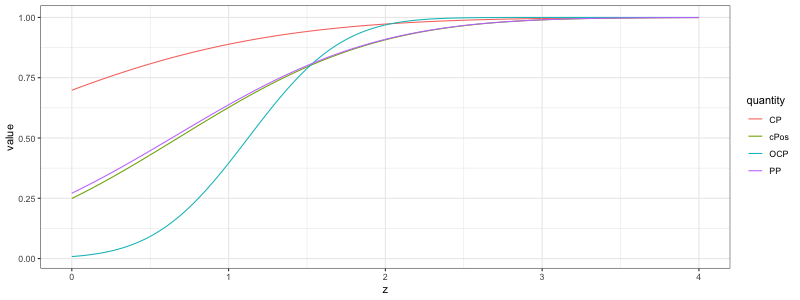

RObject{VecSxp}


In [13]:
zm = 0:0.005:4

tbl_absolute = DataFrame(
      z = zm,
     CP = CP.(zm, n, m, crit, 0.4),
    OCP = OCP.(zm, n, m, crit),
     PP = PP.(zm, n, m, crit, φ),
   cPos = cPoS.(zm, n, m, crit, φ)
)

RCall.rcall_p(:options, rcalljl_options=Dict(:width => 800, :height => 300))
R"
$tbl_absolute %>% 
    pivot_longer(-z, names_to = 'quantity') %>%
    ggplot() +
        aes(z, value, color = quantity) +
        geom_line() +
        theme_bw()
"

Clearly, OCP is the most sensitive measure while CP is the least sensitive. Intuitively, this should be clear since CP assumes a fixed effect size and is this only directly affected by changes in $z_m$ whereas OCP and PP are also indireclty affected by updating the belief about the true effect size with the interim results. 
PP does so in a principled way by invoking the Bayes theorem. 
The degree of adaptation depends on the vagueness of the prior. 
The plug-in estimate OCP simply assumes that the observed effect is the true effect. 
THis ignores any sampling uncertainy about the observed effect and is not well justified.
The conditional PoS is very similar to PP since the posterior probability of a non-null effect is almost 1. 
Note that the two are *not* proportional due to the Bayesian updating of the prior and thus the factor $\Pr[\,\Theta >0\cond Z_m = z_m\,]$ not being constant in $z_m$.

To make this distinction (see als ... certainly discussed at length before) more tangible, we can decompose the variability of the respecitve measures with respect to changes in $z_m$ into the indirect variability due to changes in assumptions about $\theta$ and direct variability due to changes in $z_m$ using the chain rule.
Let to this end 
\begin{align}
    f(z_m, c, \theta) :&= \frac{\partial}{\partial z_m}\CP(z_m, c, \theta) = \phi\left(
            \frac{c - \sqrt{n}\,\theta - \sqrt{\tau} \, z_m + \sqrt{m}\,\theta
            }{\sqrt{1 - \tau}}
        \right) \ \sqrt{\frac{\tau}{1 - \tau}}\, z_m \\
    g(z_m, c, \theta) :&= \frac{\partial}{\partial \theta}\CP(z_m, c, \theta) = \phi\left(
            \frac{c - \sqrt{n}\,\theta - \sqrt{\tau} \, z_m + \sqrt{m}\,\theta
            }{\sqrt{1 - \tau}}
        \right) \ \frac{\sqrt{n} - \sqrt{m}}{\sqrt{1 - \tau}}\, \theta
\end{align}
be the partial derivatives of $\CP(z_m, c, \theta)$ with respect to $z_n$ and to $\theta$.
Then the following decomposition of the overall change in $\CP(z_m,\crit,\theta_1)$ due to changes in $z_m$
\begin{align}
    \frac{\partial}{\partial z_m} \CP(z_m,\crit,\theta_1) &= f(z_m,\crit,\theta_1) \frac{\partial}{\partial z_m} z_m 
    + g(z_m,\crit,\theta_1)\, \frac{\partial}{\partial z_m} \,\theta_1 \\
    &= \underbrace{f(z_m,\crit,\theta_1)}_{\text{variation due to change in observed test statistic}}
    \quad + \quad \underbrace{0\cdot g(z_m,\crit,\theta_1)}_{\text{variation due to change in belief about underlying effect size}} \\
    &= f(z_m,\crit,\theta_1)
\end{align}
decouples the effects due to changes in the belief about the underlying parameter value (here $0$) and those due to a mere change of $z_m$ without updating the belief about $\theta$.
Clearly, for ACP, the change is exclusively driven by the latter component since
$\theta_1$ is fixed, irrespective of the observed $z_m$.

The same method can be applied to $\OCP(z_m,\crit)$ and yields the
following decomposition
\begin{align}
    \frac{\partial}{\partial z_m} \OCP(z_m,\crit) &= f(z_m,\crit,z_m\!/\!\sqrt{m}) \frac{\partial}{\partial z_m} z_m 
    + g(z_m,\crit,z_m\!/\!\sqrt{m})\, \frac{\partial}{\partial z_m} \,z_m\!/\!\sqrt{m} \\
    &= f(z_m,\crit,z_m\!/\!\sqrt{m}) 
    + 1/\sqrt{m} \, g(z_m,\crit,z_m\!/\!\sqrt{m}) \ .
\end{align}
This shows that observed conditional power indeed reacts to changes in
the observed test statistic via two distinct mechanisms.
The relative contribution of changes in belief about the true value of $\theta$ is maximal in the beginning ($m=1$) and then successively diminishes.
This is sensible since for large $m\approx n$, even a large change in the belief about $\theta$ cannot offset the fact that only few ($n-m\approx0$)
observations remain to be made.

Predictive power is usually proposed as a compromise between $\CP(z_m,\crit,\theta_1)$ and $\OCP(z_m,\crit)$ since it also considers variation due to changes in the belief about $\theta$ but in a more principles way via Bayesian updating of the prior density $\varphi$.
Here, the decomposition is given as 
\begin{align}
    \frac{\partial}{\partial z_m} \PP(z_m,\crit) 
        &= \int_{0}^{\infty} \frac{\partial}{\partial z_m} \CP(z_m, \crit, \theta)\,\frac{\varphi(\theta\cond Z_m=z_m)}{\Pr[\,\Theta\geq0\cond Z_m=z_m\,]}\operatorname{d}\theta \\
        & \quad + \int_{0}^{\infty} \CP(z_m, \crit, \theta)\,\frac{\partial}{\partial z_m}\,\frac{\varphi(\theta\cond Z_m=z_m)}{\Pr[\,\Theta\geq0\cond Z_m=z_m\,]}\operatorname{d}\theta \ .
\end{align}
Of course, the exact weighing of the individual terms depends on the
choice of prior.

In [14]:
∇2posterior(θ, zm, m, prior) = gradient(zm -> posterior(θ, zm, m, prior), zm)[1]
∇2cposterior(θ, zm, m, prior) = gradient(zm -> cposterior(θ, zm, m, prior), zm)[1]


∇1CP(zm, n, m, c, θ) = gradient(zm ->  CP(zm, n, m, c, θ), zm)[1]
∇2CP(zm, n, m, c, θ) = gradient(θ ->  CP(zm, n, m, c, θ), θ)[1]

OCP(zm, n, m, c) = CP(zm, n, m, c, zm/sqrt(m))
∇OCP(zm, n, m, c) = gradient(zm -> OCP(zm, n, m, c), zm)[1]


function ∇1PP(zm, n, m, c, prior)
    f(θ) = ∇1CP.(zm, n, m, c, θ) * cposterior.(θ, zm, m, prior)
    integrate(f, 0)
end
function ∇2PP(zm, n, m, c, prior)
    f(θ) = CP.(zm, n, m, c, θ) * ∇2cposterior.(θ, zm, m, prior)
    integrate(f, 0)
end

function ∇1cPoS(zm, n, m, c, prior)
    f(θ) = ∇1CP.(zm, n, m, c, θ) * posterior.(θ, zm, m, prior)
    integrate(f, 0)
end
function ∇2cPoS(zm, n, m, c, prior)
    f(θ) = CP.(zm, n, m, c, θ) * ∇2posterior.(θ, zm, m, prior)
    integrate(f, 0)
end

∇2cPoS (generic function with 1 method)

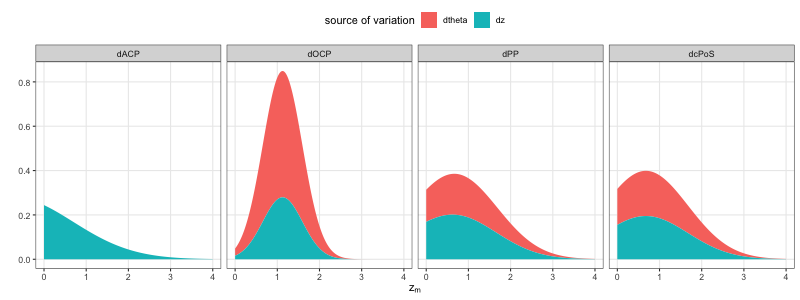

RObject{VecSxp}


In [15]:
zm = 0:0.005:4

tbl = DataFrame(
             zm = zm,
        dACP_dz = ∇1CP.(zm, n, m, crit, 0.4),
        dOCP_dz = ∇1CP.(zm, n, m, crit, zm ./ sqrt(m)),
         dPP_dz = ∇1PP.(zm, n, m, crit, φ),
    dOCP_dtheta = ∇2CP.(zm, n, m, crit, zm ./ sqrt(m)) ./ sqrt(m),
     dPP_dtheta = ∇2PP.(zm, n, m, crit, φ),
       dcPoS_dz = ∇1cPoS.(zm, n, m, crit, φ),
   dcPoS_dtheta = ∇2cPoS.(zm, n, m, crit, φ)
)

RCall.rcall_p(:options, rcalljl_options=Dict(:width => 800, :height => 300))
R"
$tbl %>%
    pivot_longer(-zm) %>%
    separate(name, c('quantity', 'source of variation'), sep = '_') %>%
    mutate(
        quantity = factor(quantity, levels = c('dACP', 'dOCP', 'dPP', 'dcPoS'))
    ) %>%
    ggplot() + 
        aes(zm, value, fill = `source of variation`) + 
        geom_area(position = position_stack()) + 
        facet_wrap(~quantity, nrow = 1) + 
        labs(x = expression(z[m]), y = '') +
        theme_bw() +
        theme(
             legend.position = 'top',
            panel.grid.minor = element_blank()
        )
"

The figure shows the absolute variation (derivative) and the proportion by source (direct, dz or indirect dtheta).
Clearly, OCP is not only the most variable but also the change is mostly driven by the implicit changes in the belief about $\theta$. 
For predictive power this balance is goverened by the prior variability. 
cPoS is slightly more variable than PP due to the additional variation in the probability of a non-null effect. 

In [16]:
ggsave("sources-of-variation.pdf", width = 8, height = 4)

RObject{NilSxp}
NULL


One may also look at ACP, OCP, and PP from and estimation perspective. 
If the goal is to estimate the unknown $\CP(z_m, \crit, \theta)$, ACP, OCP, and PP can be seen as estimators. 
We can then compare them in terms of their precision, e.g., using the mean absolute error and bias.

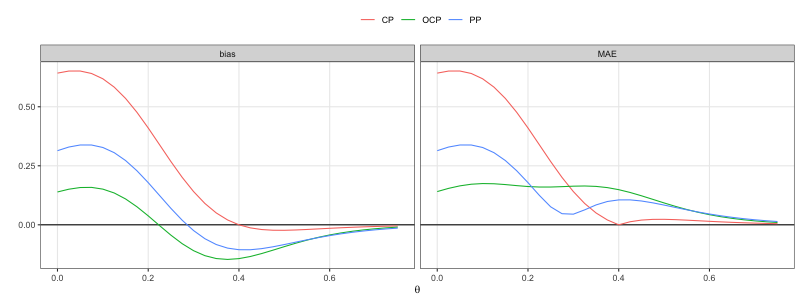

RObject{VecSxp}


In [17]:
# reuse the sample for smoothness
smpl = rand(Normal(0, 1), 1000)

function sim(θ, m)
    zm     = smpl .+ √(m)*θ
    truecp = CP.(zm, n, m, crit, θ)
     CP_ = mean(abs.(CP.(zm, n, m, crit, 0.4) .- truecp))
    OCP_ = mean(abs.(OCP.(zm, n, m, crit) .- truecp))
     PP_ = mean(abs.(PP.(zm, n, m, crit, φ) .- truecp))
    CP_, OCP_, PP_
end

θ = 0:0.025:0.75

res = [sim(θ, m) for θ in θ]
res = transpose(hcat([[a...] for a in res]...))
tbl_mae = DataFrame(
    theta = θ,
       CP = res[:,1],
      OCP = res[:,2],
       PP = res[:,3]
)

function sim(θ, m)
    zm     = smpl .+ √(m)*θ
    truecp = CP.(zm, n, m, crit, θ)
     CP_ = mean(CP.(zm, n, m, crit, 0.4) .- truecp)
    OCP_ = mean(OCP.(zm, n, m, crit) .- truecp)
    PP_ = mean(PP.(zm, n, m, crit, φ) .- truecp)
    CP_, OCP_, PP_
end

res = [sim(θ, m) for θ in θ]
res = transpose(hcat([[a...] for a in res]...))
tbl_bias = DataFrame(
    theta = θ,
       CP = res[:,1],
      OCP = res[:,2],
       PP = res[:,3]
)

R"
bind_rows(
        mutate($tbl_mae, quantity = 'MAE'),
        mutate($tbl_bias, quantity = 'bias')
    ) %>%
    pivot_longer(-c(theta, quantity)) %>%
    ggplot() +
        aes(theta, value, color = name) +
        geom_hline(yintercept = 0) +
        geom_line() +
        facet_wrap(~quantity) +
        labs(x = expression(theta), y = '', color = '') +
        theme_bw() + 
        theme(
            legend.position = 'top',
            panel.grid.minor = element_blank()
        )
"

Clearly, the high sensitivity of OCP leads to a high but consistent MAE as cmpared to CP, which is very good close to the assumed parameter value but very bad for much smaller true values of $\theta$. Again,the Bayesian PP compromise between these extremes based on the properties of the prior.
Note that the MAE of ACP is better than that of OCP for a quite wide range of parameter values around the assumed $\theta=0.4$.

In terms of  maximal absolute bias, OCP is best, but in the relevant region even weak prior or a vague prior with wrong mean performs best. 

* CP, OCP, PP can be seen as estimators of unknown $\CP(z_m, \crit, \theta)$
* typically $m<<n$ will be small since a late change of sample size has little effect
* estmating $\theta$ is already hard after observing $n$ since the sample size is usually derived based on power arguments (80%/90%) and deciding weather or not to reject the null hypthesis is an easier problem than estimating the underlying parameter precisely
* $m<<n$ then means that the evidence on the magintude of $\theta$ during an early interim ins very sparse, i.e., the estimaton problem is even harder than at the end of the study
* the estimation problem can be stabilised using some form of regularistion and that is exactly what PP does via the Bayesian prior

## Sampling distribution of CP, OCP, PP

In [18]:
function sim(θ)
    zm   = smpl .+ √(m)*θ
     CP_ = CP.(zm, n, m, crit, 0.4)
    OCP_ = OCP.(zm, n, m, crit)
     PP_ = PP.(zm, n, m, crit, φ)
   cPoS_ = cPoS.(zm, n, m, crit, φ)
     tbl = convert(DataFrame, [zeros(1000) .+ θ CP_ OCP_ PP_ cPoS_])
    rename!(tbl, [:theta, :CP, :OCP, :PP, :cPoS])
end

sim (generic function with 2 methods)

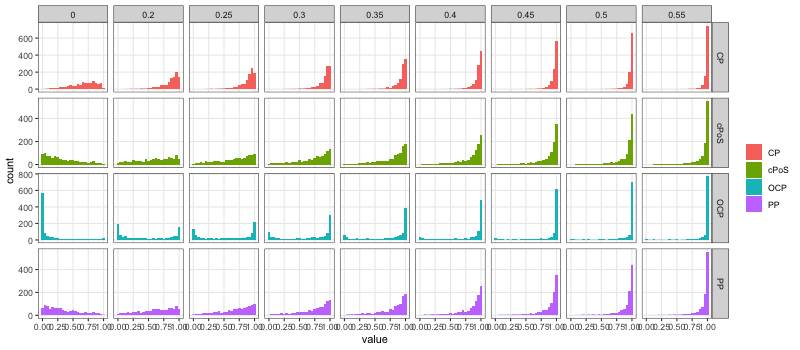

RObject{VecSxp}


In [19]:
tbl_sim = [sim(θ) for θ in vcat(0, 0.2:0.05:0.55)] |> 
    x -> vcat(x...)

RCall.rcall_p(:options, rcalljl_options=Dict(:width => 800, :height => 350))
R"
$tbl_sim %>%
    pivot_longer(-theta) %>%
    ggplot() +
        aes(value, fill = name) +
        geom_histogram(bins = 25, position = 'identity') + 
        facet_grid(name ~ theta, scales = 'free_y') +
        scale_fill_discrete('') + 
        theme_bw() +
        theme(
            panel.grid.minor = element_blank()
        )
"

Note that, for CP and PP estimate $\CP(z_m, \crit, \theta)$ *conditonal* on $\theta\geq 0$. 
This is consistent with their use in sample size recalculation since it is only sensible to recalculate the sample size under the assumption of a positive effct. OCP on the other hand does not conditon on the existance of a positve effect (if $z_m$ is negative). 
It is thus better suited to estimate the probability of rejecting the null hypothesis. 
If that is indeed the goal, one could also just use the marginal Bayesian probability of rejecting the null. 
Note, however, that such an unconditional quantity should NOT be used to reassess sample size!

cPoS addresses neither of these issues sice it is unconditional but restricted to $\Theta>0$. 

## Back to example: recalculation?

This unplanned interim analysis could have two of the following goals:

1. Adjust the final sample size to $n'<n_{max}$ such that the probability of rejecting the null at the end of the trial given the data observed so far is sufficiently large without violating strict type one error rate control.
2. Assess the prospects of reaching the study goal after recruiting all $n'$ individuals and stop the trial for futility if the chances are too small. Early futility stopping never incurs a type one error rate penalty!

The first problem can be addressed by solving

\begin{align}
    \operatorname{argmin}(n', c') \quad & n' \\
    \text{ subject to} \quad & \PP_{n'}(z_m, c') \geq 1 - \beta \\
                      &  \CP_{n'}(z_m, c', 0) \leq \CP(z_m, \crit, 0) \\
                      &  m <= n'_{min} \leq n' \leq n_{max} \ . 
\end{align}

Here, the first condition ensures that *the probability of rejecting the null at the end of the trial given the data observed so far is sufficiently large* while the second condition ensures type one error rate control via the conditional error principle and the third ensures that the upper sample size boundary is respected (and we don't go back in time). 
The lower boundary $n'_{min}$ is set to ensure a minimal sample size for the remaining study (otherwise operation costs not justified).

Note that 

* Requirement (1.) naturally leads to the use of predictive power, conditional power is only used to evaluate the conditional type one error rate since this is not affected by uncertainty.
* When the lower boundary is hit, the critical value is not identifieable from the above given formulation. In that case we just $\CP_{n_min}(z_m, c', 0) = \CP(z_m, \crit, 0)$ for the given sample $n_min$ size to obtain the adjusted critical value.

Assume that $n'_{min} = 30, n_{max} = 160$ and $1-\beta=0.8$.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



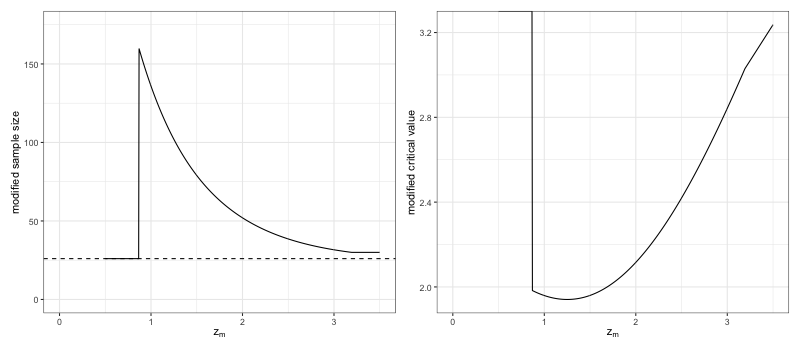

RObject{VecSxp}


In [20]:
n_min = 30
n_max = 160
    β = 0.2

function adapt(zm, n_min, n_max, threshold, prior)
    α′ = CP(zm, n, m, crit, 0.0)
    mdl = Model(optimizer_with_attributes(Ipopt.Optimizer, "max_cpu_time" => 60.0, "print_level" => 0))
    # pretty sensitive to starting values
    @variable(mdl, 0.8*crit <= crit′<= 2*crit, start = crit)
    @variable(mdl, n_min <= n′ <= n_max, start = max(m + 2, n/zm))
    @objective(mdl, Min, n′)
    cp_(n′, crit′) = CP(zm, n′, m, crit′, 0.0)
    register(mdl, :cp_, 2, cp_; autodiff = true)
    pp_(n′, crit′) = PP(zm, n′, m, crit′, prior)
    register(mdl, :pp_, 2, pp_; autodiff = true)
    @NLconstraint(mdl , cp_(n′, crit′) <= cp_(n, crit))
    @NLconstraint(mdl , pp_(n′, crit′) >= threshold)
    optimize!(mdl)
    if Int(termination_status(mdl)) == 4
        res = [value(n′), value(crit′)] 
    else
        if zm > 3
            return [n_min, -Inf]
        else
            return [m, Inf]
        end
    end
    if round(res[1]) == n_min # hit lower bound, refit with conditional error equality to get critical value
        mdl = Model(optimizer_with_attributes(Ipopt.Optimizer, "max_cpu_time" => 60.0, "print_level" => 0))
        @variable(mdl, crit <= crit′ <= crit + zm/2, start = crit)
        register(mdl, :cp_, 2, cp_; autodiff = true)
        @NLconstraint(mdl , cp_(res[1], crit′) == cp_(n, crit))
        optimize!(mdl)
        res[2] = value(crit′)
    end
    return res
end

         zm = 0.5:0.005:3.5
        res = hcat(zm, hcat(adapt.(zm, n_min, n_max, 1 - β, φ)...)')
        res = res[.!isnan.(res[:, 2]), :]
tbl_adapted = convert(DataFrame, res)
rename!(tbl_adapted, [:zm, :nprime, :cprime])

RCall.rcall_p(:options, rcalljl_options=Dict(:width => 800, :height => 350))
R"
plt1 <- ggplot($tbl_adapted) +
    aes(zm, nprime) +
    geom_line() +
    geom_hline(yintercept = 26, linetype = 2) + 
    scale_x_continuous(expression(z[m]), limits = c(0, 3.5)) +
    scale_y_continuous('modified sample size', limits = c(0, 175)) +
    theme_bw()
plt2 <- ggplot($tbl_adapted) +
    aes(zm, cprime) +
    geom_line() +
    scale_x_continuous(expression(z[m]), limits = c(0, 3.5)) +
    scale_y_continuous('modified critical value') +
    theme_bw()
plt1 + plt2
"

Here, the maximal sample size implies a futility boundary since the criterion would not allow continuation with more than 80% predictive power within the set maximum of 160 subjects. 

We can also asses the conditional properties of the solution directly:

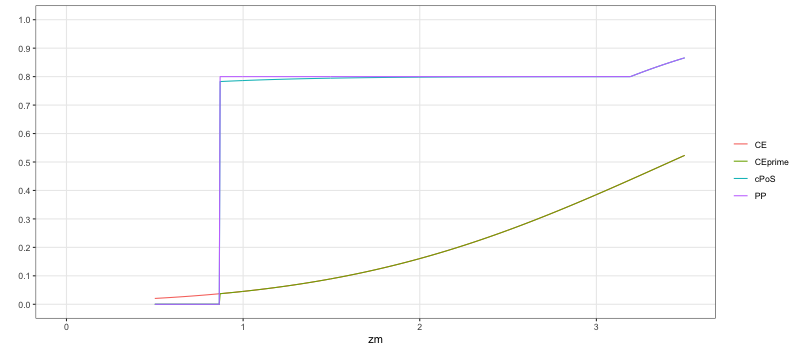

RObject{VecSxp}


In [21]:
tbl_adapted[:, :cPoS] = cPoS.(tbl_adapted[:, :zm], tbl_adapted[:, :nprime], m, tbl_adapted[:, :cprime], φ)
tbl_adapted[:, :PP] = PP.(tbl_adapted[:, :zm], tbl_adapted[:, :nprime], m, tbl_adapted[:, :cprime], φ)
tbl_adapted[:, :CEprime] = CP.(tbl_adapted[:, :zm], tbl_adapted[:, :nprime], m, tbl_adapted[:, :cprime], 0.0)
tbl_adapted[:, :CE] = CP.(tbl_adapted[:, :zm], n, m, crit, 0.0)
tbl_adapted

R"
$tbl_adapted %>%
    select(zm, cPoS, PP, CEprime, CE) %>%
    pivot_longer(-zm, names_to = 'name', values_to = 'value') %>%
    ggplot() +
        aes(zm, value, color = name) +
        geom_line() +
        scale_x_continuous('zm', limits = c(0, 3.5)) +
        scale_y_continuous('', limits = c(0, 1), breaks = seq(0, 1, .1)) +
        scale_color_discrete('') +
        theme_bw() +
        theme(
            panel.grid.minor = element_blank()
        )
"

Since the prior is relatively optimistic, $\PoS(\crit\cond z_m)\approx\PP(z_m, \crit)$.
A stricter futility boundary based on cPoS is thus really necessary. 
Note that cPoS should not be used to adapt the sample size directly for the same reasons that PoS is ill-suited for sample size calculation.
In situations with a less optimistic prior, however, cPoS can be substantially smaller than PP.

## Properties of the binding recalculation design

We now look at the properties of the two-stage design that results from making the above recalculation procedure binding.

In [22]:
marginal_pdf(zm, m, prior) = integrate(θ -> pdf.(Normal(√(m).*θ), zm) .* prior.(θ)) 

function cmarginal_pdf(zm, m, prior) 
    # condition prior on effect > 0
    normalizing_constant = integrate(prior, 0)
               cprior(θ) = prior(θ) / normalizing_constant
    integrate(θ -> pdf(Normal(√(m)*θ, 1), zm) * cprior(θ), 0)
end

# define interval to integrate
cfut = tbl_adapted[findlast(tbl_adapted[:, :cprime] .== Inf) + 1, :zm]
ceff = tbl_adapted[findfirst(tbl_adapted[:, :nprime] .== n_min) - 1, :zm]
prfut = 1 - integrate(zm -> marginal_pdf(zm, m, φ), cfut)
preff = integrate(zm -> marginal_pdf(zm, m, φ), ceff)

ess = integrate(zm -> marginal_pdf(zm, m, φ) .* adapt(zm, n_min, n_max, 1 - β, φ)[1], cfut, ceff) + 
    prfut * m + 
    preff * n_min

toer = integrate(
        zm -> pdf.(Normal(), zm) .* 
            CP(zm, adapt(zm, n_min, n_max, 1 - β, φ)[1], m, adapt(zm, n_min, n_max, 1 - β, φ)[2], 0), 
        cfut
    )

ep1 = integrate(
        zm -> cmarginal_pdf(zm, m, φ) .* 
            PP(zm, adapt(zm, n_min, n_max, 1 - β, φ)[1], m, adapt(zm, n_min, n_max, 1 - β, φ)[2], φ), 
        cfut, ceff
    )
ep2 = integrate(
        zm -> cmarginal_pdf(zm, m, φ) .* 
            PP(zm, adapt(zm, n_min, n_max, 1 - β, φ)[1], m, adapt(zm, n_min, n_max, 1 - β, φ)[2], φ), 
        ceff, 15
    )
ep = ep1 + ep2

@show ess, toer, ep

(ess, toer, ep) = (48.25488124127254, 0.017787737139843204, 0.672026784578603)


(48.25488124127254, 0.017787737139843204, 0.672026784578603)

Clearly, the expected sample size is much smaller than before but also the mTOER is reduced and the expected power is lower than the initially planned 80%. I.e., the test does not have much in common with the original design goals.
There are certainly ways to fix this (e.g. the 'missing' $\alpha$ could be redistributed, never reducing original sample size etc.) but practical hacks do not address the underlying flaws of the approach. 

## Optimal adaptive designs

An analytical approach of deriving an optimal adaptation function for a particular setting is described in [Optimal Conditional Error Functions for the Control of Conditional Power].
A generalisation via the variational perspective was given in [A variational approach to optimal two‐stage designs] and [JSS].

Note that although the authors in [Optimal Conditional Error Functions for the Control of Conditional Power] start with methods from unplanned adaptations, they essentially end up solving the problem

\begin{align}
    \operatorname{argmin}(m, n(\cdot), c(\cdot)) \quad & \operatorname{E}[\,n(z_m)\,] \\
    \text{ subject to} \quad 
        & \Pr_{0}[\,Z_{n(Z_m)} > c(Z_m)\,] \leq \alpha \\
        & \Pr[\,Z_{n(Z_m)} > c(Z_m)\cond\Theta > 0 \,] \geq 1 - \beta \\
        & \PP(z_m, c(z_m)) \geq 1 - \beta_c \ .
\end{align}

This is an unconditional problem with an additional conditional constraint on the conditional power[biostats paper, JSS]. 
Further note, that the objective criterion is necessarily different than for the single-stage design where one could simply minimize the sample size. 
For two-stage designs, the sample size is a (usually) deterministic function of the observed effect at the interim analysis, $n(Z_m)$, and thus a random variable.
As such, only a functional of its distribution can be minimized.
The formulation here implicitly limits the number of pre-planned interim analyses to 1, but the same principle could be applied to multiple interim analyses.
It is well known that the returns of more interim analyses are diminishing quickly though [???] and we focus on the 0 vs 1 interim analyses comparison to simplify notation.

A single-stage design is optimal when minimising $\operatorname{E}[\,n(Z_m)\,] + \eta\,\operatorname{V}[\,n(Z_m)\,]$ for $\eta\to\infty$, i.e.

\begin{align}
    \lim_{\eta\to\infty}\operatorname{argmin}(m, n(\cdot), c(\cdot)) \quad & \operatorname{E}[\,n(z_m)\,] + \eta\,\operatorname{V}[\,n(Z_m)\,]\\
    \text{ subject to} \quad 
        & \Pr_{0}[\,Z_{n(Z_m)} > c(Z_m)\,] \leq \alpha \\
        & \Pr[\,Z_{n(Z_m)} > c(Z_m)\cond\Theta > 0 \,] \geq 1 - \beta \ .
\end{align}


A comparison between the single stage design and the 'optimal adaptive' one derived via problem xxx-yyy is thus of limited use since they optimize quite different objectives.

## Conditional power constraints for optimal single-stage designs

To level the playing field, we can restrict the analysis to single-stage designs first. 
The optimal single-stage design is then the solution of 

\begin{align}
    &\operatorname{argmin}(n, c) \quad & n                                   &  \\
    &\text{subject to} \quad          & \Pr_{0}[\,Z_{n} > c\,]              & \leq \alpha \\
    &                                  & \Pr[\,Z_{n} > c \cond\Theta > 0 \,] & \geq 1 - \beta \ .
\end{align}

One may then wonder whether the same problem *with additional conditional power constraint* 
\begin{align}
    &\operatorname{argmin}(n, c) \quad & n & \\
    &\text{subject to} \quad          & \Pr_{0}[\,Z_{n} > c\,]              & \leq \alpha \\
    &                                  & \Pr[\,Z_{n} > c \cond\Theta > 0 \,] & \geq 1 - \beta \\
    &    & \PP(z_n, c) &\geq 1 - \beta_c  \quad \forall z_n
\end{align}

even has a solution. 
This is obviously not the case since $\PP(z_n, c) \geq 1 - \beta_c \ \forall z_n$ cannot be fulfilled for any $1 - \beta_c>0$ since $\lim_{z_n\to\infty}\PP(z_n, c) = 0$. 

## Conditional power contraints for optimal two-stage designs

In optimal two stage designs, the justification for the predictive power constraint is still a bit unclear since it is not necessary from and unconditional perspective.

We can first solve the problem without predictive power constraint

\begin{align}
    \operatorname{argmin}(m, n(\cdot), c(\cdot)) \quad & \operatorname{E}[\,n(z_m)\,] \\
    \text{ subject to} \quad 
        & \Pr_{0}[\,Z_{n(Z_m)} > c(Z_m)\,] \leq \alpha \\
        & \Pr[\,Z_{n(Z_m)} > c(Z_m)\cond\Theta > 0 \,] \geq 1 - \beta 
\end{align}

[note look at truncated normal prior]

In [23]:
R"
  H0 <- PointMassPrior(.0, 1)
  H1 <- ContinuousPrior(function(theta) dnorm(theta, 0.5, 0.2)/(pnorm(1, 0.5, 0.2) - pnorm(-1, 0.5, 0.2)), c(-1, 1))
 ESS <- ExpectedSampleSize(Normal(two_armed = FALSE), H1)
  EP <- Power(Normal(two_armed = FALSE), condition(H1, c(0, 1)))
TOER <- Power(Normal(two_armed = FALSE), H0)
  PP <- ConditionalPower(Normal(two_armed = FALSE), condition(H1, c(0, 1)))
"

RObject{S4Sxp}
Pr[x2>=c2(x1)|x1]<Normal<single-armed>;ContinuousPrior<[0,1]>> 


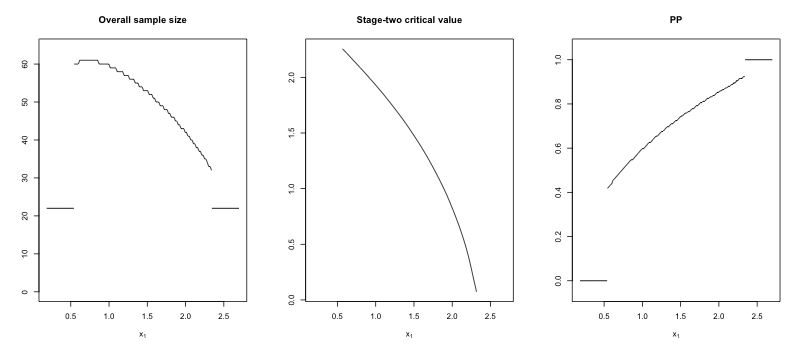

RObject{VecSxp}
$mfrow
[1] 1 3



In [24]:
R"
no_pp_cnstr <- minimize(
    ESS,
    subject_to(
          EP >= 0.8,
        TOER <= 0.025
    ),
    get_initial_design(
        theta = .4,
        alpha = .025,
        beta  = .2,
        type  = 'two-stage',
        dist  = Normal(two_armed = FALSE),
        order = 9L
    )
)$design

plot(no_pp_cnstr, PP = PP)
"

In [25]:
R"summary(no_pp_cnstr, ESS = ESS, `mTOER` = TOER, `Expected Power` = EP)"

RObject{VecSxp}
TwoStageDesign: n1 =  22 
                futility |                        continue                       | efficacy
            x1:     0.54 |  0.57  0.69  0.89  1.15  1.44  1.73  1.99  2.19  2.31 |  2.34
        c2(x1):     +Inf | +2.25 +2.17 +2.02 +1.81 +1.54 +1.21 +0.84 +0.44 +0.09 |  -Inf
        n2(x1):        0 |    38    39    38    36    32    26    20    15    11 |     0
           ESS:     33.158
         mTOER:      0.025
Expected Power:      0.802


Imposing the PP constraint leads to the following problem

\begin{align}
    \operatorname{argmin}(m, n(\cdot), c(\cdot)) \quad & \operatorname{E}[\,n(z_m)\,] \\
    \text{ subject to} \quad 
        & \Pr_{0}[\,Z_{n(Z_m)} > c(Z_m)\,] \leq \alpha \\
        & \Pr[\,Z_{n(Z_m)} > c(Z_m)\cond\Theta > 0 \,] \geq 1 - \beta \\
        & \PP(z_m, c(z_m)) \geq 1 - \beta_c \ .
\end{align}

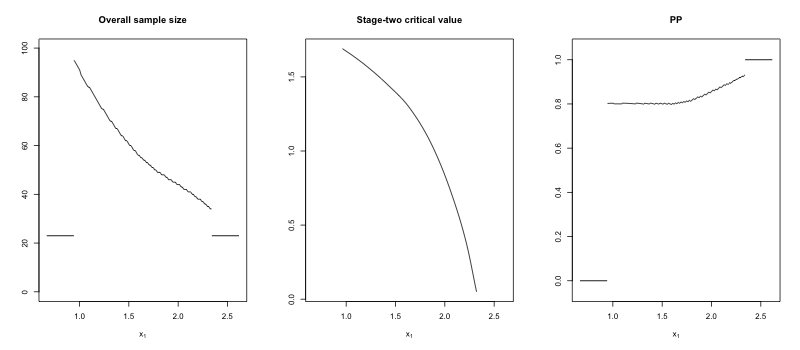

RObject{VecSxp}
$mfrow
[1] 1 3



In [26]:
R"
with_pp_cnstr <- minimize(
    ESS,
    subject_to(
          EP >= 0.8,
        TOER <= 0.025,
          PP >= 0.8
    ),
    get_initial_design(
        theta = .4,
        alpha = .025,
        beta  = .2,
        type  = 'two-stage',
        dist  = Normal(two_armed = FALSE),
        order = 9L
    )
)$design

plot(with_pp_cnstr, PP = PP)
"

In [27]:
R"summary(with_pp_cnstr, ESS = ESS)"

RObject{VecSxp}
TwoStageDesign: n1 =  23 
          futility |                        continue                       | efficacy
      x1:     0.95 |  0.97  1.06  1.21  1.42  1.64  1.87  2.07  2.22  2.32 |  2.34
  c2(x1):     +Inf | +1.69 +1.65 +1.57 +1.45 +1.29 +1.04 +0.71 +0.36 +0.07 |  -Inf
  n2(x1):        0 |    70    63    53    42    31    24    19    15    11 |     0
     ESS:     33.986


Clearly, the design without the additional constraint has lower expected (and maximal) sample size at the cost of a potentially low predictive power. 
Although the PP design might be more intuitive, from an unconditional planning perspective, there is little reason to prefer it, especially when considering the variability of the sample size. [link to fishers exact test?]

## Conditional power contraints for unplanned adaptations

The previous considerations are all about pre-planning optimal adaptation rules. 
This is fundamentally different from unplanned design adaptation. 
For unplanned adaptation, a (not necessarily optimal) design is given and stopped at some $m<n$. 
Here we restrict the considerations to a single stage design $(n, c)$. 
All considerations can be extended to multistage designs though.

The minimal predictive power constraint can also be critizised from the perspective of unplanned adaptations.
Going back to the 'ad-hoc adaptation' discussed earlier, 
it is clear that there is an assymetry with respect to how type-one and type-two error rates conditional on $Z_m=z_m$ are handled.
For the conditional type one error rate, the conditional error principle is invoked to ensure that the overall error level is not inflated. 
For the predictive power (expected conditional type two error rate) however an arbitrary fixed threshold is used. 

Instead, one could also apply the conditional error principle to both the maximal type one error rate and type two error rate, i.e., require

\begin{align}
    \PP_{n'}(z_m, c') &\geq \PP_{n}(z_m, \crit) \\
    \CP_{n'}(z_m, c', 0) &\leq \CP_{n}(z_m, \crit, 0),\ n'_{min} \leq n' \leq n_{max}, m < n'_{min} \ .
\end{align}

Trivially, the original design would then be invariant under recalculation since the original $(n, \crit)$ satisfies all constraints with equality and the two constraints already determine $(n', c')$ uniquely.

If the orignal design $(n,c)$ was obtained as solution to an optimaization problem, e.g.,

\begin{align}
    &\operatorname{argmin}(n, c) \quad & n                                   &  \\
    &\text{subject to} \quad          & \Pr_{0}[\,Z_{n} > c\,]              & \leq \alpha \\
    &                                  & \Pr[\,Z_{n} > c \cond\Theta > 0 \,] & \geq 1 - \beta \ 
\end{align}

and there is no new trial-external information, why should the optimal design be changed? 
In fact, one could make the case that this 'invariance priniple' should always hold if the original design was planned thoroughly.

[I removed the adapt2 approach; it was only to confirm that I did not overlook anything; the recalculated design is indeed invariant]

So, when does an unplanned sample size adaptation make sense then? 
There are mainly two reasons, 

1. the original design wa planned badly, e.g., there is a desire to change the power levels or similar
2. there is new trial-external evidence that lead to a change in the prior from $\varphi$ to $\psi$.

In both situations, one would still like to maintain strict type one error rate control for the final hypothesis test after adaptation (conditional error principle).

Focusssing on (2.), a natural criterion to determine the required sample size of the remaining trial could be to
maintain the same chances of detecting an effect under the new prior given the data as had been planned for under the old prior.
This leads to the conditional problem 

\begin{align}
    &\operatorname{argmin}(n', c') \quad & n' &\\
    &\text{subject to} \quad & \Pr_{0}[\,Z_{n'} > c'\cond Z_m=z_m\,] &\leq \Pr_{0}[\,Z_{n} > c\cond Z_m=z_m\,] \\
        & & \Pr_\psi[\,Z_{n'} > c' \cond \Theta > 0,Z_m=z_m \,] &\geq \Pr_\varphi[\,Z_{n} > c \cond \Theta > 0,Z_m=z_m \,]  \ .
\end{align}

The interesting modification is the constraint $\Pr_\psi[\,Z_{n'} > c' \cond \Theta > 0, Z_m=z_m \,] \geq \Pr_\varphi[\,Z_{n} > c \cond \Theta > 0, Z_m=z_m \,]$.
Since the prior on the left hand side is different, the original $(n, c)$ will no longer fulfill the constraints leading to a new solution. 

[this is what I conjured up, not sure I already hit home here. The crucial question is: how do you map the original unconditional power constraint to the conditional situation? I oppose $PP > 1-beta_c$ because 1) it treats type one and type two error rates fundamentally different and 2) the original design would not be invariant under no prior change! Esp. the latter one should be a core criterion for any adaptive design modification!]

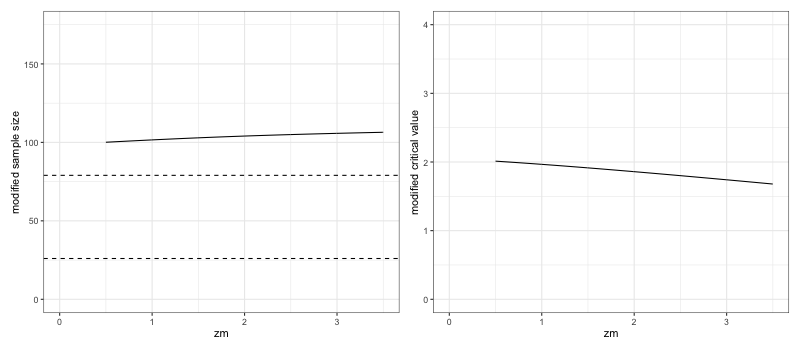

RObject{VecSxp}


In [28]:
function adapt3(zm, n_min, n_max, priorold, priornew)
    α′ = CP(zm, n, m, crit, 0.0)
    β′ = 1 - PP(zm, n, m, crit, priorold)
    mdl = Model(optimizer_with_attributes(Ipopt.Optimizer, "max_cpu_time" => 60.0, "print_level" => 0))
    # pretty sensitive to starting values
    @variable(mdl, 0.8*crit <= crit′<= 2*crit, start = crit)
    @variable(mdl, n_min <= n′ <= n_max, start = max(m + 2, n/zm))
    @objective(mdl, Min, n′)
    cp_(n′, crit′) = CP(zm, n′, m, crit′, 0.0)
    register(mdl, :cp_, 2, cp_; autodiff = true)
    pp_(n′, crit′) = PP(zm, n′, m, crit′, priornew)
    register(mdl, :pp_, 2, pp_; autodiff = true)
    @NLconstraint(mdl , cp_(n′, crit′) <= cp_(n, crit))
    @NLconstraint(mdl , pp_(n′, crit′) >= 1 - β′)
    optimize!(mdl)
    if Int(termination_status(mdl)) == 4
        res = [value(n′), value(crit′)] 
    else
        if zm > 3
            return [n_min, -Inf]
        else
            return [m, Inf]
        end
    end
    if round(res[1]) == n_min # hit lower bound, refit with conditional error equality to get critical value
        mdl = Model(optimizer_with_attributes(Ipopt.Optimizer, "max_cpu_time" => 60.0, "print_level" => 0))
        @variable(mdl, crit <= crit′ <= crit + zm/2, start = crit)
        register(mdl, :cp_, 2, cp_; autodiff = true)
        @NLconstraint(mdl , cp_(res[1], crit′) == cp_(n, crit))
        optimize!(mdl)
        res[2] = value(crit′)
    end
    return res
end

ψ(θ) = pdf(Normal(0.3, 0.2), θ)

 res = hcat(zm, hcat(adapt3.(zm, n_min, n_max, φ, ψ)...)')
         res = res[.!isnan.(res[:, 2]), :]
tbl_adapted3 = convert(DataFrame, res)
rename!(tbl_adapted3, [:zm, :nprime, :cprime])

R"
plt1 <- ggplot($tbl_adapted3) +
    aes(zm, nprime) +
    geom_line() +
    geom_hline(yintercept = 26, linetype = 2) + 
    geom_hline(yintercept = 79, linetype = 2) + 
    scale_x_continuous('zm', limits = c(0, 3.5)) +
    scale_y_continuous('modified sample size', limits = c(0, 175)) +
    theme_bw()
plt2 <- ggplot($tbl_adapted3) +
    aes(zm, cprime) +
    geom_line() +
    scale_x_continuous('zm', limits = c(0, 3.5)) +
    scale_y_continuous('modified critical value', limits = c(0, 4)) +
    theme_bw()
plt1 + plt2
"

[Now this is a bit surprising since the sample size increases in $z_m$, why?
It is the wrong way of looking at it. The plot treats $z_m$ as variable and the prior mean as fixed; it is the other way around!]

We look at the recalculated sample size as function of the new prior mean for $z_m\approx1,2,3$.

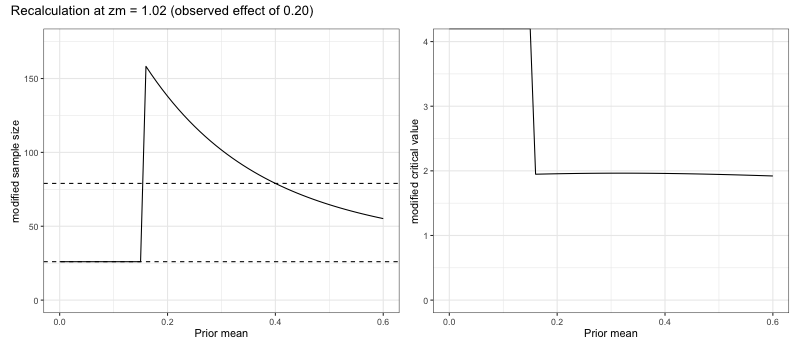

RObject{VecSxp}


In [29]:
function adapt4(zm, n_min, n_max, priorold, priornewmean)
    α′ = CP(zm, n, m, crit, 0.0)
    β′ = 1 - PP(zm, n, m, crit, priorold)
    mdl = Model(optimizer_with_attributes(Ipopt.Optimizer, "max_cpu_time" => 60.0, "print_level" => 0))
    # pretty sensitive to starting values
    @variable(mdl, 0.8*crit <= crit′<= 2*crit, start = crit)
    @variable(mdl, n_min <= n′ <= n_max, start = max(m + 2, n/zm))
    @objective(mdl, Min, n′)
    cp_(n′, crit′) = CP(zm, n′, m, crit′, 0.0)
    register(mdl, :cp_, 2, cp_; autodiff = true)
    pp_(n′, crit′) = PP(zm, n′, m, crit′, θ -> pdf(Normal(priornewmean, 0.2), θ))
    register(mdl, :pp_, 2, pp_; autodiff = true)
    @NLconstraint(mdl , cp_(n′, crit′) <= cp_(n, crit))
    @NLconstraint(mdl , pp_(n′, crit′) >= 1 - β′)
    optimize!(mdl)
    if Int(termination_status(mdl)) == 4
        res = [value(n′), value(crit′)] 
    else
        if zm > 3
            return [n_min, -Inf]
        else
            return [m, Inf]
        end
    end
    if round(res[1]) == n_min # hit lower bound, refit with conditional error equality to get critical value
        mdl = Model(optimizer_with_attributes(Ipopt.Optimizer, "max_cpu_time" => 60.0, "print_level" => 0))
        @variable(mdl, crit <= crit′ <= crit + zm/2, start = crit)
        register(mdl, :cp_, 2, cp_; autodiff = true)
        @NLconstraint(mdl , cp_(res[1], crit′) == cp_(n, crit))
        optimize!(mdl)
        res[2] = value(crit′)
    end
    return res
end

         res = hcat(0:0.01:0.6, hcat(adapt4.(sqrt(m)*0.2, n_min, n_max, φ, 0:0.01:0.6)...)')
         res = res[.!isnan.(res[:, 2]), :]
tbl_adapted4 = convert(DataFrame, res)
rename!(tbl_adapted4, [:priormean, :nprime, :cprime])

R"
plt1 <- ggplot($tbl_adapted4) +
    aes(priormean, nprime) +
    geom_line() +
    geom_hline(yintercept = 26, linetype = 2) + 
    geom_hline(yintercept = 79, linetype = 2) + 
    scale_x_continuous('Prior mean') +
    scale_y_continuous('modified sample size', limits = c(0, 175)) +
    theme_bw()
plt2 <- ggplot($tbl_adapted4) +
    aes(priormean, cprime) +
    geom_line() +
    scale_x_continuous('Prior mean') +
    scale_y_continuous('modified critical value', limits = c(0, 4)) +
    theme_bw()
plt1 + plt2 + plot_annotation(
    title = sprintf('Recalculation at zm = %.2f (observed effect of %.2f) ', sqrt(26)*0.2, 0.2)
)
"

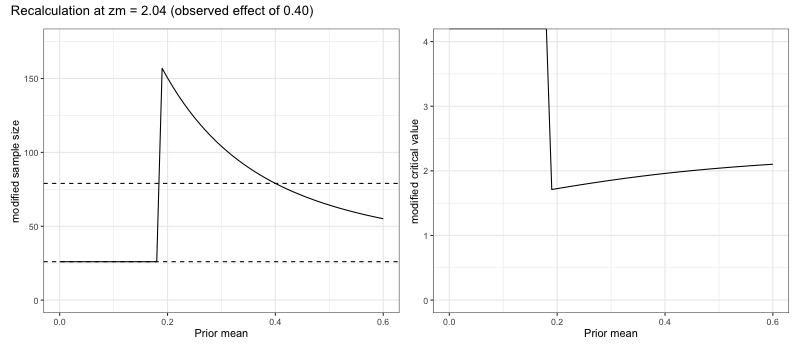

RObject{VecSxp}


In [30]:
         res = hcat(0:0.01:0.6, hcat(adapt4.(sqrt(26)*0.4, n_min, n_max, φ, 0:0.01:0.6)...)')
         res = res[.!isnan.(res[:, 2]), :]
tbl_adapted5 = convert(DataFrame, res)
rename!(tbl_adapted5, [:priormean, :nprime, :cprime])

R"
plt1 <- ggplot($tbl_adapted5) +
    aes(priormean, nprime) +
    geom_line() +
    geom_hline(yintercept = 26, linetype = 2) + 
    geom_hline(yintercept = 79, linetype = 2) + 
    scale_x_continuous('Prior mean') +
    scale_y_continuous('modified sample size', limits = c(0, 175)) +
    theme_bw()
plt2 <- ggplot($tbl_adapted5) +
    aes(priormean, cprime) +
    geom_line() +
    scale_x_continuous('Prior mean') +
    scale_y_continuous('modified critical value', limits = c(0, 4)) +
    theme_bw()
plt1 + plt2 + plot_annotation(
    title = sprintf('Recalculation at zm = %.2f (observed effect of %.2f) ', sqrt(26)*0.4, 0.4)
)
"

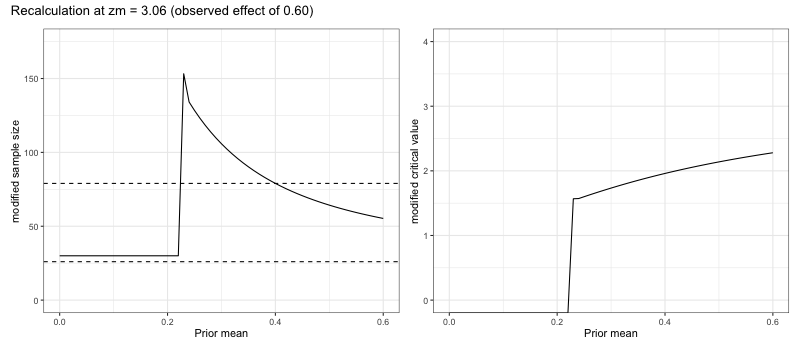

RObject{VecSxp}


In [31]:
         res = hcat(0:0.01:0.6, hcat(adapt4.(sqrt(26)*0.6, n_min, n_max, φ, 0:0.01:0.6)...)')
         res = res[.!isnan.(res[:, 2]), :]
tbl_adapted6 = convert(DataFrame, res)
rename!(tbl_adapted6, [:priormean, :nprime, :cprime])

R"
plt1 <- ggplot($tbl_adapted6) +
    aes(priormean, nprime) +
    geom_line() +
    geom_hline(yintercept = 26, linetype = 2) + 
    geom_hline(yintercept = 79, linetype = 2) + 
    scale_x_continuous('Prior mean') +
    scale_y_continuous('modified sample size', limits = c(0, 175)) +
    theme_bw()
plt2 <- ggplot($tbl_adapted6) +
    aes(priormean, cprime) +
    geom_line() +
    scale_x_continuous('Prior mean') +
    scale_y_continuous('modified critical value', limits = c(0, 4)) +
    theme_bw()
plt1 + plt2 + plot_annotation(
    title = sprintf('Recalculation at zm = %.2f (observed effect of %.2f) ', sqrt(26)*0.6, 0.6)
)
"

Most importantly, the original design is invariant under this criterion.

[suprisingly similar across different $z_m$]

### An alternative approach to localising the power constraint

The approach for adjusting the sample size to a change in the study-external information outline above crucially depends on the requirement that one wants to *'maintain the same chances of detecting an effect under the new prior given the data as had been planned for under the old prior'*
for 'localising' the power constraint (i.e. apply the condiitonal error principle to type two error rates as well to derive a cnstraint for the PP).

An alternative approach of defining a conditional power constraint that is consistent with the original unconditional problem when the prior is unchanged is to avoid the predictive power constraint entirely by exploiting the duality between constraint minimisation and penalised optimisation.
I.e., for suitable $\lambda$ the original unconditional problem

\begin{align}
    \operatorname{argmin}(n, c) \quad & n \\
    \text{ subject to} \quad 
        & \Pr_{0}[\,Z_n > c\,] \leq \alpha \\
        & \Pr_\varphi[\,Z_n > c\cond\Theta > 0 \,] \geq 1 - \beta \ .
\end{align}

is equivalent to

\begin{align}
     \operatorname{argmin}(n, c) \quad & n - \lambda\,\Pr_\varphi[\,Z_n > c\cond\Theta > 0 \,]\\
    \text{ subject to} \quad 
        & \Pr_{0}[\,Z_n > c\,] \leq \alpha \ .
\end{align}

where $\lambda$ is the 'price of power'. 
If we then assume that $\lambda$ does not change, the conditional problem is simply 

\begin{align}
    \operatorname{argmin}(n', c') \quad & n' - \lambda\,\Pr_\psi[\,Z_{n'} > c'\cond Z_m = z_m, \Theta > 0 \,] \\
    \text{ subject to} \quad 
        & \Pr_{0}[\,Z_{n'} > c'\cond Z_m = z_m\,] \leq \Pr_{0}[\,Z_{n} > c\cond Z_m = z_m\,]   \ .
\end{align}

Should there be reason to adjust the 'price of power' to $\lambda'$ this can also be reflected by replacing $\lambda$ with $\lambda'$.
Again, the solution to the problem is trivially invariant if $\lambda$ and $\varphi$ remain unchanged, i.e., the reclaculation is consistent with the original design as long as the assumptions don't change.

[TODO: implement, get $\lambda$ elegantly via lagrange multiplier?]

In [32]:
# step one identify λ
function get_n(λ)
    mdl =  Model(optimizer_with_attributes(Ipopt.Optimizer, "max_cpu_time" => 60.0, "print_level" => 0))
    @variable(mdl, 0 <= n′)
    function EP(n′) 
             norm = integrate(φ, 0)
        cprior(θ) = φ(θ)/norm
        integrate(θ -> (1 - cdf(Normal(√(n′)*θ, 1), crit)) * cprior(θ), 0)
    end
    register(mdl, :EP, 1, EP; autodiff = true)
    @NLobjective(mdl, Min, n′ - λ*EP(n′))
    optimize!(mdl)
    value(n′)
end

λ = collect(400:500)[findmin(abs.(get_n.(400:500) .- 79))[2]]
@show get_n(λ), λ

(get_n(λ), λ) = (78.9797902311222, 457)


(78.9797902311222, 457)

We can then set up the conditional optimisation problem using the original price $\lambda$

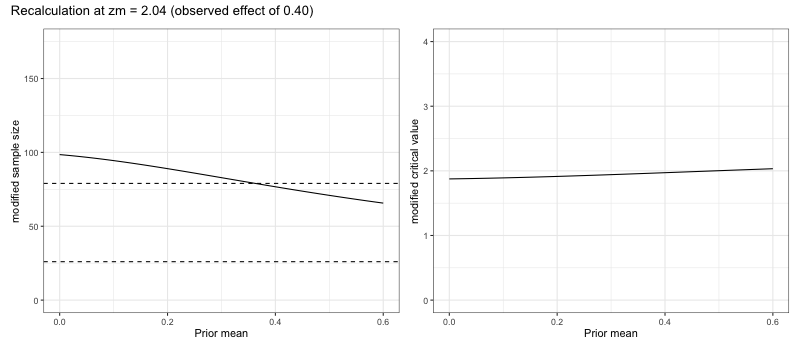

RObject{VecSxp}


In [33]:
function adapt5(zm, n_min, n_max, λ, priornewmean)
    α′ = CP(zm, n, m, crit, 0.0)
    mdl = Model(optimizer_with_attributes(Ipopt.Optimizer, "max_cpu_time" => 60.0, "print_level" => 0))
    # pretty sensitive to starting values
    @variable(mdl, 0.8*crit <= crit′<= 2*crit, start = crit)
    @variable(mdl, n_min <= n′ <= n_max, start = max(m + 2, n/zm))
    cp_(n′, crit′) = CP(zm, n′, m, crit′, 0.0)
    register(mdl, :cp_, 2, cp_; autodiff = true)
    pp_(n′, crit′) = PP(zm, n′, m, crit′, θ -> pdf(Normal(priornewmean, 0.2), θ))
    register(mdl, :pp_, 2, pp_; autodiff = true)
    @NLobjective(mdl, Min, n′ - λ*pp_(n′, crit′))
    @NLconstraint(mdl , cp_(n′, crit′) <= cp_(n, crit))
    optimize!(mdl)
    if Int(termination_status(mdl)) == 4
        res = [value(n′), value(crit′)] 
    else
        if zm > 3
            return [n_min, -Inf]
        else
            return [m, Inf]
        end
    end
    if round(res[1]) == n_min # hit lower bound, refit with conditional error equality to get critical value
        mdl = Model(optimizer_with_attributes(Ipopt.Optimizer, "max_cpu_time" => 60.0, "print_level" => 0))
        @variable(mdl, crit <= crit′ <= crit + zm/2, start = crit)
        register(mdl, :cp_, 2, cp_; autodiff = true)
        @NLconstraint(mdl , cp_(res[1], crit′) == cp_(n, crit))
        optimize!(mdl)
        res[2] = value(crit′)
    end
    return res
end

         res = hcat(0:0.01:0.6, hcat(adapt5.(sqrt(26)*0.4, n_min, n_max, λ, 0:0.01:0.6)...)')
         res = res[.!isnan.(res[:, 2]), :]
tbl_adapted7 = convert(DataFrame, res)
rename!(tbl_adapted7, [:priormean, :nprime, :cprime])

R"
plt1 <- ggplot($tbl_adapted7) +
    aes(priormean, nprime) +
    geom_line() +
    geom_hline(yintercept = 26, linetype = 2) + 
    geom_hline(yintercept = 79, linetype = 2) + 
    scale_x_continuous('Prior mean') +
    scale_y_continuous('modified sample size', limits = c(0, 175)) +
    theme_bw()
plt2 <- ggplot($tbl_adapted7) +
    aes(priormean, cprime) +
    geom_line() +
    scale_x_continuous('Prior mean') +
    scale_y_continuous('modified critical value', limits = c(0, 4)) +
    theme_bw()
plt1 + plt2 + plot_annotation(
    title = sprintf('Recalculation at zm = %.2f (observed effect of %.2f) ', sqrt(26)*0.4, 0.4)
)
"

## Summary

1. use PP, generalizes ACP; OCP theoretically ill justified
2. never use methodology for unplanned adaptation to derive a 'binding recalculation rule' - always optimize directly!
3. there is no good reason to constrain PP, it will only decrease unconditional performance. Only 'looks nicer' 
4. if the original design was chosen optimal and the planning assumptions haven't changed, the original design should be invariant under an unplanned recalculation. Vice versa, an unplanned recalculation is only ever warranted when the planning assumptions (incl. trial external information) change; never solely as consequence of data that is observed within trial. ('never change a winning team')
6. There are different ways of 'localising' the power constraint